In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import math
import seaborn as sns

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook



In [66]:

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
apple_data = pd.read_csv('../ML-Project/apple.csv')

#print the head
apple_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj_Close,Volume,Year,Quarter
0,0,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.953873,28781900,2017,1
1,1,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.829704,21118100,2017,1
2,2,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.393303,22193600,2017,1
3,3,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.635139,31751900,2017,1
4,4,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.666824,33561900,2017,1


In [67]:
apple = apple_data.drop(columns='Unnamed: 0')
apple.head()

,Date,Open,High,Low,Close,Adj_Close,Volume,Year,Quarter
0,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.953873,28781900,2017,1
1,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.829704,21118100,2017,1
2,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.393303,22193600,2017,1
3,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.635139,31751900,2017,1
4,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.666824,33561900,2017,1


There are multiple variables in the dataset – date, open, high, low, close, & volume.

The columns open and close represent the starting and final price at which the stock is traded on a particular day. High and low represent the maximum, minimum, and last price of the share for the day. Volume is the number of shares bought or sold in the day.

Another important thing to note is that the market is closed on weekends and public holidays. Thats's why in the table some date values are missing.

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

In [44]:
apple.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'], dtype='object')

In [16]:
#apple_df = df.drop(columns =['Quarterly Dates', 'Net Income', 'Net Sales', 'Operating Income', 'Profit', 'Year', 'Quarter']) 

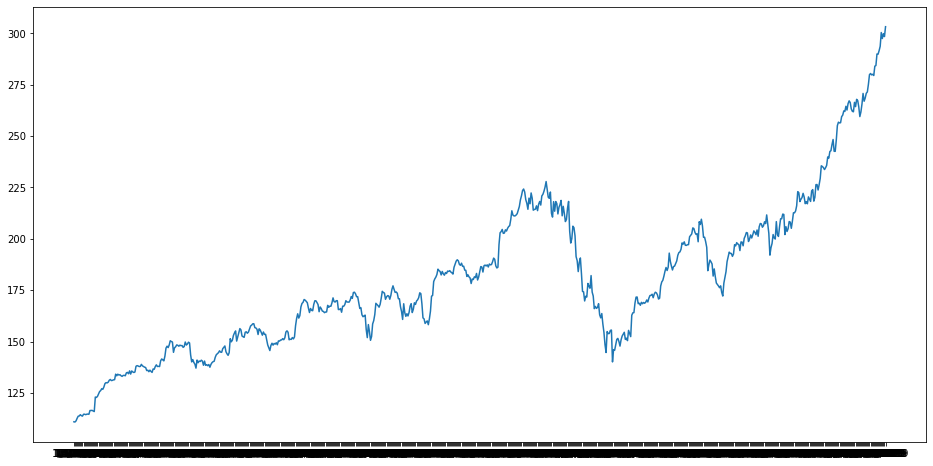

In [54]:
#setting index as date
#apple['Date'] = pd.to_datetime(apple_data.Date,format='%Y-%m-%d')
#apple.index = apple['Date']
#plot
plt.figure(figsize=(16,8))
plt.plot(apple['Adj_Close'], label='Close Price history')





In the upcoming sections, we will explore these variables and use different techniques to predict the daily closing price of the stock.

Linear Regression
Introduction

The most basic machine learning algorithm that can be implemented on this data is linear regression. The linear regression model returns an equation that determines the relationship between the independent variables and the dependent variable.

The equation for linear regression can be written as:

Here, x1, x2,….xn represent the independent variables while the coefficients θ1, θ2, …. θn represent the weights. You can refer to the following article to study linear regression in more detail:

we do not have a set of independent variables. We have only the dates instead. Let us use the date column to extract features like – day, month, year, mon/fri etc. and then fit a linear regression model.

Implementation

We will first sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data.

In [27]:

#sorting
data = df.sort_index(ascending=True, axis=0)
#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Open', 'High', 'Low', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Open'][i] = data['Open'][i]
    new_data['High'][i] = data['High'][i]
    new_data['Low'][i] = data['Low'][i]
    new_data['Close'][i] = data['Close'][i]






In [28]:
new_data['Date'].dt.day_name()
new_data['Dow'] = new_data['Date'].dt.day_name()
new_data.head()


,Date,Open,High,Low,Close,Dow
0,2017-01-03 00:00:00,115.8,116.33,114.76,116.15,Tuesday
1,2017-01-04 00:00:00,115.85,116.51,115.75,116.02,Wednesday
2,2017-01-05 00:00:00,115.92,116.864,115.81,116.61,Thursday
3,2017-01-06 00:00:00,116.78,118.16,116.47,117.91,Friday
4,2017-01-09 00:00:00,117.95,119.43,117.94,118.99,Monday


In [31]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dow'][i] == 'Monday' or new_data['Dow'][i] == 'Friday'):
    
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [32]:
new_data.head()

,Date,Open,High,Low,Close,Dow,mon_fri
0,2017-01-03 00:00:00,115.8,116.33,114.76,116.15,Tuesday,0
1,2017-01-04 00:00:00,115.85,116.51,115.75,116.02,Wednesday,0
2,2017-01-05 00:00:00,115.92,116.864,115.81,116.61,Thursday,0
3,2017-01-06 00:00:00,116.78,118.16,116.47,117.91,Friday,1
4,2017-01-09 00:00:00,117.95,119.43,117.94,118.99,Monday,1


In [33]:
df = new_data.drop(columns =['Dow']) 
df.head()

,Date,Open,High,Low,Close,mon_fri
0,2017-01-03 00:00:00,115.8,116.33,114.76,116.15,0
1,2017-01-04 00:00:00,115.85,116.51,115.75,116.02,0
2,2017-01-05 00:00:00,115.92,116.864,115.81,116.61,0
3,2017-01-06 00:00:00,116.78,118.16,116.47,117.91,1
4,2017-01-09 00:00:00,117.95,119.43,117.94,118.99,1


In [10]:
df[target_close] = df[:date][1:]

NameError: name 'date' is not defined

In [ ]:
# Set features. This will also be used as your x values.
target = df["close"] # this is y value
data = df.drop("close", axis=1) # this is X value
feature_names = data.columns

In [ ]:
#split into train and test
from sklearn.model_selection import train_test_split
#split training and testing data
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=84)

In [ ]:

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)


In [ ]:
#make predictions and find the rmse
prediction = model.predict(X_test)
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(prediction)),2)))
rms

